#  Prédiction avec Word2Vec et Keras



<a href="https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&security.allowlist.enabled=false&init.personalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
<br>
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=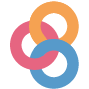)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=/__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)
[![githubdev](https://open.vscode.dev/badges/open-in-vscode.svg)](https://github.dev/linogaliana/python-datascientist//__w/python-datascientist/python-datascientist/notebooks/course/NLP/04_word2vec.ipynb)

Cette page approfondit certains aspects présentés dans la
[partie introductive](#nlp). Après avoir travaillé sur le
*Comte de Monte Cristo*, on va continuer notre exploration de la littérature
avec cette fois des auteurs anglophones :

* Edgar Allan Poe, (EAP) ;
* HP Lovecraft (HPL) ;
* Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles ici : [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv) et peuvent être requétées via l'url 
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.

Le but va être d'essayer de prédire quel texte correspond à quel auteur à partir d'un modèle `Word2Vec`.

Les chapitres précédents permettaient de mieux comprendre les enjeux
du nettoyage de documents textuels et la modélisation de documents
par une approche fréquentiste. On va ici aller plus loin dans la modélisation
en utilisant un réseau de neurones grâce au package `Keras`.

Ce notebook librement inspiré de  : 

* https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
* https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
* https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook

## Librairies nécessaires

Cette page évoquera, les principales librairies pour faire du NLP, notamment: 

* [WordCloud](https://github.com/amueller/word_cloud)
* [nltk](https://www.nltk.org/)
* [spacy](https://spacy.io/)
* [Keras](https://keras.io/)
* [TensorFlow](https://www.tensorflow.org/)

Comme dans la [partie précédente](#nlp), il faut télécharger quelques éléments pour que `NTLK` puisse fonctionner correctement. Pour cela, faire :


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')

Comme nous allons utiliser également `spacy`, il convient de télécharger
le corpus Anglais. Pour cela, on peut se référer à
[la documentation de `spacy`](https://spacy.io/usage/models),
extrèmement bien faite.

- Idéalement, il faut installer le module via la ligne de commande. Dans
une cellule de notebook `Jupyter`, faire :


In [ ]:
!python -m spacy download en_core_web_sm

- Sans accès à la ligne de commande (depuis une instance `Docker` par exemple),
faire :


In [ ]:
import spacy

In [ ]:
spacy.cli.download("en_core_web_sm")

- Sinon, il est également possible d'installer le module en faisant pointer
`pip install` depuis le fichier adéquat sur
[`Github`](https://github.com/explosion/spacy-models). Pour cela, taper

~~~python
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl
~~~


La liste des modules à importer est assez longue, la voici:


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from IPython.display import display
import base64
import string
import re
import nltk

from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

## Données utilisées

*Si vous avez déjà lu la section précédente et importé les données, vous
pouvez passer à la section suivante*

Le code suivant permet d'importer le jeu de données `spooky`: 


In [ ]:
import pandas as pd

url='https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv'
import pandas as pd
train = pd.read_csv(url,
                    encoding='latin-1')
train.columns = train.columns.str.capitalize()
                    
train['ID'] = train['Id'].str.replace("id","")
train = train.set_index('Id')

Le jeu de données met ainsi en regard un auteur avec une phrase qu'il a écrite:


In [ ]:
train.head()

```
##                                                       Text Author     ID
## Id                                                                      
## id26305  This process, however, afforded me no means of...    EAP  26305
## id17569  It never once occurred to me that the fumbling...    HPL  17569
## id11008  In his left hand was a gold snuff box, from wh...    EAP  11008
## id27763  How lovely is spring As we looked from Windsor...    MWS  27763
## id12958  Finding nothing else, not even gold, the Super...    HPL  12958
```

## Prédiction - Modélisation en utilisant Word2vec et Keras

Jusqu'à présent, nous avons utilisé principalement `nltk` pour le 
*preprocessing* de données textuelles. Cette fois, nous proposons
d'utiliser la librairie `spaCy` qui permet de mieux automatiser sous forme de
*pipeline* de *preprocessing*. 




In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

On va utiliser une fonction standardisée pour nettoyer les champs textuels
avec `spacy`. Idéalement, on pourrait utiliser un `pipe` `spacy`. Mais là
on va privilégier une fonction :


In [ ]:
punctuations = string.punctuation
from nltk.corpus import stopwords  
stop_words = spacy.lang.en.STOP_WORDS

def preprocess_text(text):
    doc = text
    doc = nlp(doc, disable=['parser', 'ner','tagger'])
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in stop_words and tok not in punctuations]
    tokens = ' '.join(tokens)
    return(tokens)

train['text_clean'] = train['Text'].apply(preprocess_text)
#train.head()

```
## /opt/conda/envs/python-ENSAE/lib/python3.9/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
##   warnings.warn(Warnings.W108)
```

<!-- TO BE CONTINUED -->